<a href="https://colab.research.google.com/github/sampad-singha/Alzheimer_Disease_Detection/blob/main/ResNet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Mount Drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Create Dataset**

**Train Set**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds_dir = "/content/drive/MyDrive/small_dataset/augmented_train_sample"
# val_ds_dir = "/content/drive/MyDrive/archive_2/data/val"
test_ds_dir = "/content/drive/MyDrive/Sm_dataset/test_sample"

image_size = (224, 224)
batch_size = 32


train_ds = image_dataset_from_directory(
  train_ds_dir,
  labels = "inferred",
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 5528 files belonging to 4 classes.
Using 4423 files for training.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1.0/255)

# Apply rescaling to the dataset
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

**Validation Set**

In [ ]:
val_ds =image_dataset_from_directory(
  train_ds_dir,
  labels = "inferred",
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 5528 files belonging to 4 classes.
Using 1105 files for validation.


**Test Set**

In [ ]:
test_ds = image_dataset_from_directory(
  test_ds_dir,
  labels = "inferred",
  label_mode='categorical',
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 3457 files belonging to 4 classes.


**Get Class Names**

In [ ]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']


**Apply Ignore Errors**

In [ ]:
# Use ignore_errors directly
train_ds = (train_ds.ignore_errors())  # Directly use ignore_errors

# Iterate over the dataset
# for images, labels in train_ds.take(5):
#     print("Batch shape:", images.shape)
#     print("Batch labels:", labels.numpy())


**Visualizing Before Preprocesing**



# **3. Pre Processing**

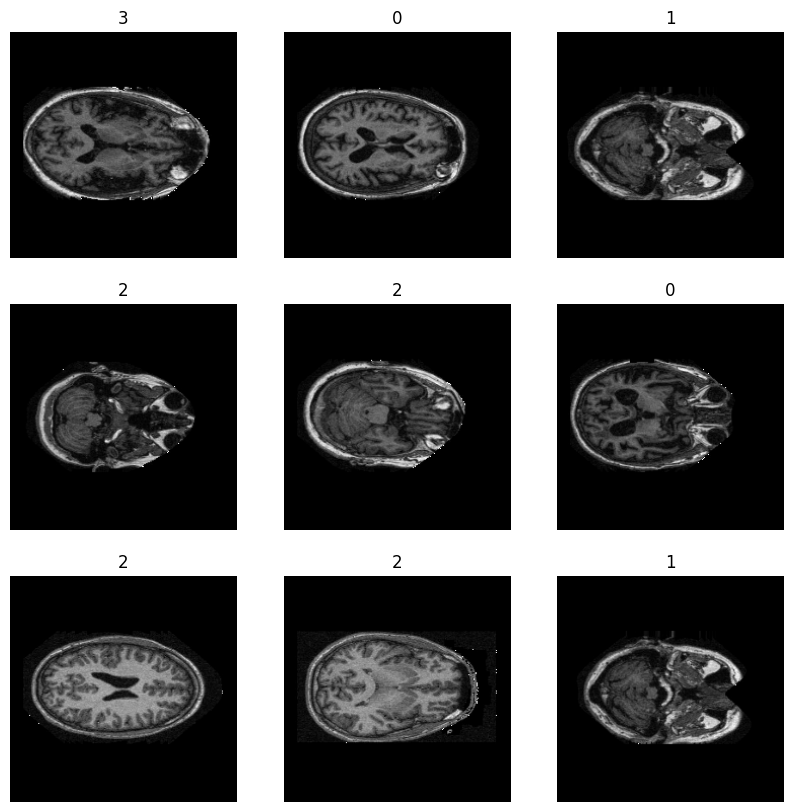

In [ ]:
#visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

In [ ]:
# Rescaling values to [0-255]
def fix_pixel_values(image, label):
    image = tf.clip_by_value(image, 0.0, 255.0)  # Clamp values to [0, 255]
    return image, label
train_ds = train_ds.map(fix_pixel_values)
val_ds = val_ds.map(fix_pixel_values)
test_ds = test_ds.map(fix_pixel_values)

In [ ]:
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Assuming 'img' is your input image


# Preprocessing function
def preprocess_image(image, label):
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)

    image = preprocess_input(image)
    # Normalize to [0, 1]
    # image = tf.cast(image, tf.float32) / 255.0
    # image = tf.image.per_image_standardization(image)
    # image = tf.keras.applications.resnet_v2.preprocess_input(image)



    # Clamp values to valid range
    # image = tf.clip_by_value(image, 0.0, 1.0)

    # Contrast stretching
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    # tf.print(max_val)
    # tf.print(min_val)

    # image = (image - min_val) / (max_val - min_val + 1e-5)  # Avoid division by zero

    # Apply Gaussian filter
    # image = tfa.image.gaussian_filter2d(image, filter_shape=(5, 5), sigma=1.0)
    # tf.print("Pixel values after normalization:", tf.reshape(image, [-1])[:5])  # Print the first 100 values

    return image, label


In [ ]:
# Normalization function
# def normalize_image(image, label):
#     image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
#     return image, label


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_ds = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_ds_processed = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_processed = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_processed = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for images, labels in train_ds_processed.take(1):
    print("Normalized min pixel value:", tf.reduce_min(images).numpy())
    print("Normalized max pixel value:", tf.reduce_max(images).numpy())

Normalized min pixel value: -1.0624002
Normalized max pixel value: 1.0042229


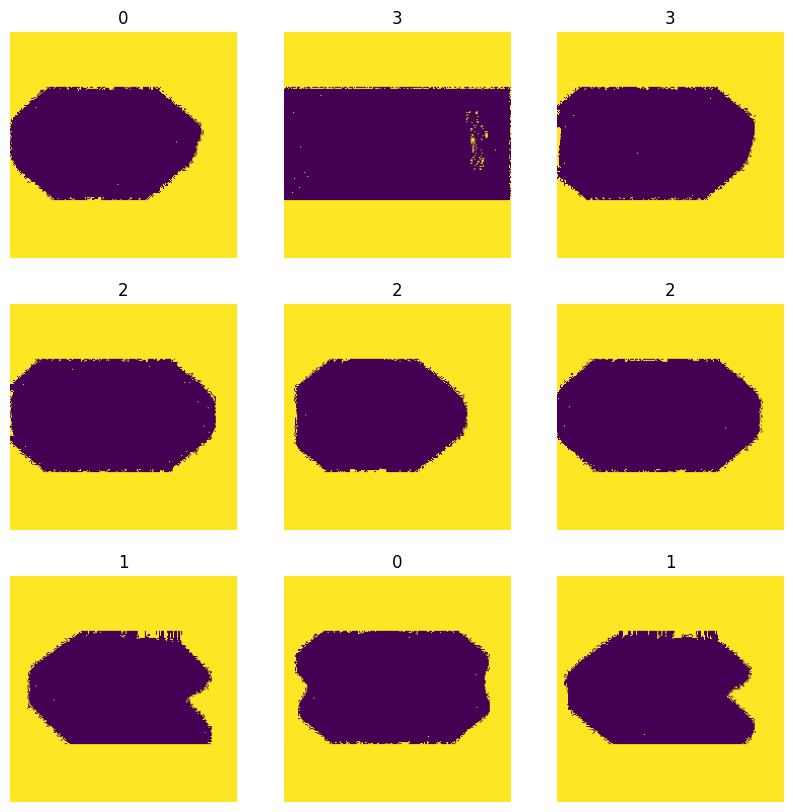

In [ ]:
#visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds_processed.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

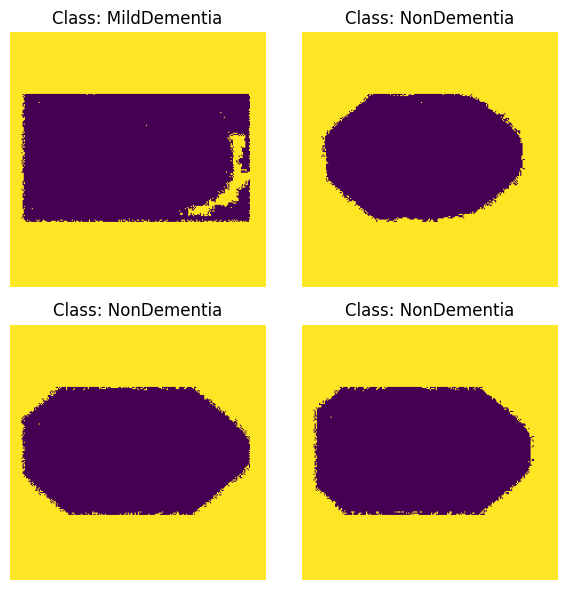

In [ ]:
import matplotlib.pyplot as plt

# Example: Replace with your actual class names

plt.figure(figsize=(6, 6))  # Adjust figure size for a square layout

# Display 4 images from train_ds_processed
for images, labels in train_ds_processed.take(1):  # Assuming train_ds_processed is defined
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)  # Create a 2x2 grid
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {class_names[int(labels[i])]}")
        plt.axis("off")

plt.tight_layout()  # Automatically adjust subplot parameters for a clean layout
plt.show()


# **4. Data Augmentation**

In [ ]:
import tensorflow as tf

def augment_image(image, label):
    # Random rotation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random brightness and contrast adjustments
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random cropping or resizing
    image = tf.image.resize_with_crop_or_pad(image, 256, 256)  # Ensure consistent size
    image = tf.image.random_crop(image, size=[224, 224, 1])

    # Random translation (width and height shifts)
    image = tf.image.resize(image, size=[224 + tf.random.uniform([], -20, 20, dtype=tf.int32),
                                         224 + tf.random.uniform([], -20, 20, dtype=tf.int32)])
    image = tf.image.resize(image, [224, 224])
    image = tf.clip_by_value(image, 0.0, 1.0)  # Clamp values to valid range

    return image, label


In [ ]:
# augment data
train_ds_aug = train_ds_processed.unbatch().map(augment_image).batch(batch_size)
# train_ds_aug = train_ds_aug.repeat()  # Infinite dataset


In [ ]:
for images, labels in train_ds_aug.take(1):
    print("Normalized min pixel value:", tf.reduce_min(images).numpy())
    print("Normalized max pixel value:", tf.reduce_max(images).numpy())

Normalized min pixel value: 0.0
Normalized max pixel value: 1.0


**Visualizing After Augmentation**

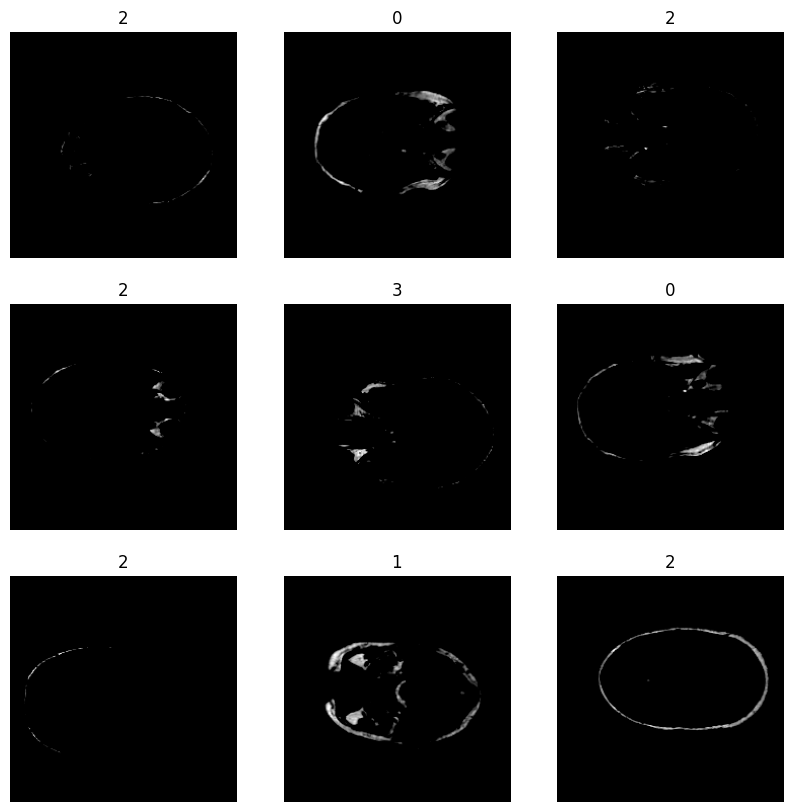

In [ ]:
#visualizing the data after preprocessing
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i], cmap="gray")
      plt.title(int(labels[i]))
      plt.axis("off")

# **5. Model**

**ResNet50v2 Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras import backend as K
# K.clear_session()


# Load the base ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add a convolutional block
x = base_model.output


x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = Activation('relu')(x)    # Activation function

x = GlobalAveragePooling2D()(x)  # can use flatten
x = Dropout(0.7)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)  # Final classification layer

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
import tensorflow as tf

# Define an exponential decay schedule
initial_learning_rate = 0.001  # Starting learning rate
decay_rate = 0.1  # Decay factor (matching exponential_decay_fn)
steps_per_epoch = len(train_ds)  # Number of batches in training dataset
decay_steps = steps_per_epoch * 20  # 20 epochs equivalent

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # If True, decay occurs in discrete steps
)
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 25,488,100 (97.23 MB)

 Trainable params: 1,923,108 (7.34 MB)

 Non-trainable params: 23,564,992 (89.89 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,             # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

In [ ]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopper]
)

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 252ms/step - accuracy: 0.3241 - auc: 0.6152 - loss: 1.3354 - val_accuracy: 0.5548 - val_auc: 0.8462 - val_loss: 0.8439
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.5342 - auc: 0.8340 - loss: 0.8785 - val_accuracy: 0.6190 - val_auc: 0.8813 - val_loss: 0.7803
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.5861 - auc: 0.8682 - loss: 0.7953 - val_accuracy: 0.6353 - val_auc: 0.8925 - val_loss: 0.7338
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.6281 - auc: 0.8889 - loss: 0.7466 - val_accuracy: 0.6326 - val_auc: 0.8892 - val_loss: 0.7412
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.6677 - auc: 0.9074 - loss: 0.6885 - val_accuracy: 0.5665 - val_auc: 0.8794 - val_loss: 0.8310
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.7118 - auc: 0.9276 - loss: 0.6213 - val_accuracy: 0.6326 - val_auc: 0.8978 - val_loss: 0.8423
Epoch 7/100
139/

In [ ]:
# # Unfreeze some layers after initial training
# for layer in pretrainted_model.layers[-10:]:  # Unfreeze the last 10 layers (as an example)
#     layer.trainable = True

# # Recompile and continue training
# resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = resnet_model.fit(train_ds_processed, validation_data=val_ds_processed, epochs=10)


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 48s 253ms/step - accuracy: 0.4992 - loss: 1.7616 - val_accuracy: 0.5140 - val_loss: 1.4208
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.7052 - loss: 0.6917 - val_accuracy: 0.7050 - val_loss: 0.7184
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 46s 221ms/step - accuracy: 0.7633 - loss: 0.5912 - val_accuracy: 0.7276 - val_loss: 0.6469
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.7906 - loss: 0.5359 - val_accuracy: 0.7792 - val_loss: 0.5599
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8180 - loss: 0.4868 - val_accuracy: 0.7828 - val_loss: 0.5393
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.8402 - loss: 0.4523 - val_accuracy: 0.8262 - val_loss: 0.4828
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.8552 - loss: 0.4093 - val_accuracy: 0.8434 - val_loss: 0.4618
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.8764 - loss: 0

In [ ]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test AUC: {results[2]}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.7776 - auc: 0.9463 - loss: 0.5986
Test Loss: 0.6212397813796997, Test Accuracy: 0.7706103324890137, Test AUC: 0.9441758990287781


**DenseNet Model**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def load_and_preprocess_image(image_path):
    # Load the image from file
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to the correct input size
    img_array = image.img_to_array(img)  # Convert the image to an array

    # Convert to grayscale (1 channel)
    img_array = tf.image.rgb_to_grayscale(img_array)  # Convert the image to grayscale

    # Normalize the image to [0, 1]
    img_array = img_array / 255.0

    # Add batch dimension: [1, height, width, channels]
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Example usage
image_path = '/content/drive/MyDrive/Sm_dataset/test_sample/Moderate Dementia/OAS1_0308_MR1_mpr-1_128.jpg'  # Path to the image you want to predict
preprocessed_image = load_and_preprocess_image(image_path)


In [ ]:
predictions = resnet_model.predict(preprocessed_image)

# If your model has multiple classes, you will get an array of probabilities
predicted_class_index = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

predicted_class_label = class_names[predicted_class_index[0]]

# Display the predicted class
print(f'Predicted class: {predicted_class_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Very mild Dementia
